# Vortex pair in potential flow

In [1]:
using Pkg
Pkg.activate("/Users/beckers/Google Drive/Academic/UCLA/CodingInProgress/ViscousFlow.jl");
using ViscousFlow
using Plots
using LinearAlgebra
using DifferentialEquations
using BenchmarkTools
# pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [2]:
mutable struct Vortex
    x::Real
    y::Real
    Γ::Real
end

In [3]:
function advect!(p::Vortex, u::Real, v::Real , Δt::Float64) where T
#     print("current position: $(p.x)\n")
#     print("velocity: $(v)\n")
#     print("updated position: $(p.x .+ v.*Δt)\n")
    p.x += u*Δt
    p.y += v*Δt
end

advect! (generic function with 1 method)

### Eulerian grid

In [4]:
nx = 32; ny = 32;
Lx = 2.0;
dx = Lx/(nx-2);
display(dx)
w = Nodes(Dual,(nx,ny));
w .= 0.0
q = Edges(Primal,(nx,ny));
ψ = Nodes(Dual,w);
L = plan_laplacian(size(w),with_inverse=true)

0.06666666666666667

Discrete Laplacian (and inverse) on a (nx = 32, ny = 32) grid with spacing 1.0

In [5]:
typeof(w)

Nodes{Dual,32,32}

### Problem parameters

In [6]:
vortex_1 = Vortex(0.6,0.6,1.0)
vortex_2 = Vortex(1.4,1.4,1.0)

vortices = Array{Vortex,1}()
push!(vortices,vortex_1)
push!(vortices,vortex_2)

tloc = 0.0

0.0

Plot original positions

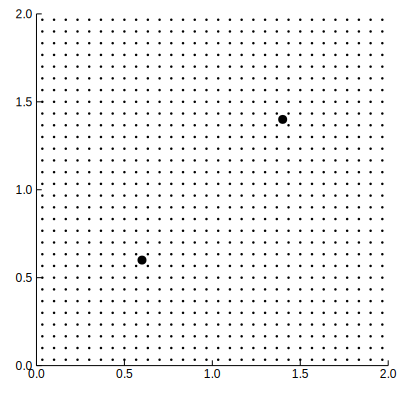

In [19]:
xg,yg = coordinates(ψ,dx=dx)
coord = [(x,y) for x in xg, y in yg]

p1 = scatter(first.(coord)[:],last.(coord)[:],markercolor=:black,
    markerstrokecolor=:black,ratio=:equal,markersize=0.5,legend=false)
scatter!((p->p.x).(vortices),(p->p.y).(vortices),c="black")
plot!(xlims=(0,Lx),ylims=(0,Lx),size=(400,400))
display(p1)
savefig("corotating_vortex_pair_grid.pdf")

In [8]:
function rhs(u,p,t)
    Γ = ScalarData(p)
    L⁻¹(w::T) where {T} = L\w;
    
    # Regularize vorticity to grid
    Hw = Regularize(VectorData(u[:,1],u[:,2]),dx;ddftype=Fields.M4prime,issymmetric=true)
    Hw(w,Γ)
    
    # Solve for streamfunction
    ψ .= -(L\(w)); 
    
    # Calculate velocity field
    q .= curl(ψ)/(dx);
    
    # Interpolate velocity to point vortex
#     vel = VectorData(Γ)
#     Hw(vel,q) # has a u and v component
#     du = [vel.u vel.v]
    
    # EDIT: interpolate to nodes before interpolating
    wx = Nodes(Dual,(nx,ny)); wy = deepcopy(wx);
    Fields.interpolate!((wx,wy),q);
    
    vel_x = ScalarData(Γ)
    vel_y = ScalarData(Γ)
    Hw(vel_x,wx)
    Hw(vel_y,wy)
    du = [vel_x vel_y]
    
end 

rhs (generic function with 1 method)

### Time marching

In [9]:
tf = 25.26
tspan = (0.0,tf);#0.25
vortices_loc = VectorData([vortex.x for vortex in vortices],[vortex.y for vortex in vortices])
vortices_Γ = ScalarData([vortex.Γ for vortex in vortices])
u0 = [vortices_loc.u vortices_loc.v]
p = vortices_Γ[:]
prob = ODEProblem(rhs,u0,tspan,p)

ODEProblem with uType Array{Float64,2} and tType Float64. In-place: false
timespan: (0.0, 25.26)
u0: [0.6 0.6; 1.4 1.4]

In [10]:
sol = solve(prob,RK4(),dense=false,saveat = 0.2);

In [11]:
# plot(sol)
# savefig("vortex_pair_rotating_goza_coordinates.pdf")
sol.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  147
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          24
Number of rejected steps:                          0

### Plot results

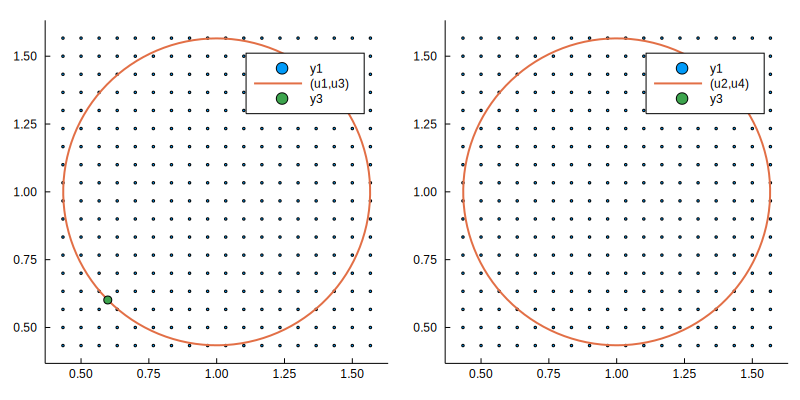

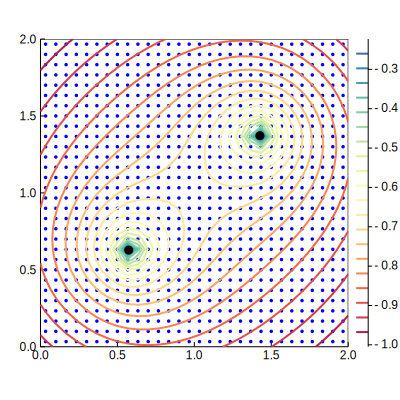

In [12]:
xg,yg = coordinates(ψ,dx=dx)
coord = [(x,y) for x in xg, y in yg]

p1 = scatter(first.(coord)[:],last.(coord)[:],ratio=:equal,markersize=1)
plot!(sol,vars=(1,3),lw=2)
scatter!([sol[end][1]],[sol[end][3]])
xlims!(minimum(sol[1,:])-1*dx,maximum(sol[1,:])+1*dx)
ylims!(minimum(sol[3,:])-1*dx,maximum(sol[3,:])+1*dx)

p2 = scatter(first.(coord)[:],last.(coord)[:],ratio=:equal,markersize=1)
plot!(sol,vars=(2,4),lw=2)
scatter!([sol[end][2]],[sol[end][4]])
xlims!(minimum(sol[2,:])-1*dx,maximum(sol[2,:])+1*dx)
ylims!(minimum(sol[4,:])-1*dx,maximum(sol[4,:])+1*dx)


p3 = plot(p1,p2,layout=(1,2),size=[800,400])
# savefig("vortex_pair_rotating_goza_trajectories.pdf")

# p4 = plot(sol,vars=[(1,3),(2,4)],lw=2,color=:black)
p4 = scatter(first.(coord)[:],last.(coord)[:],markercolor=:blue,markerstrokecolor=:blue,ratio=:equal,markersize=1,label="dual nodes",)
plot!(xg,yg,ψ,levels=20,c=:Spectral,linewidth=2,xlims=(0,Lx),ylims=(0,Lx),legend=false,size=[400,400]);
scatter!([sol[end-1][1],sol[end-1][2]],[sol[end-1][3],sol[end-1][4]],markercolor=:black)
# savefig("vortex_pair_rotating_goza.pdf")

display(p3)

display(p4)

### Create set of array of streamfunction snapshots

In [13]:
function streamfunctionSnapshot(u,Γ)
    L⁻¹(w::T) where {T} = L\w;
    
    # Regularize vorticity to grid
    Hw = Regularize(VectorData(u[:,1],u[:,2]),dx;ddftype=Fields.M4prime,issymmetric=true)
    Hw(w,Γ)
    
    # Solve for streamfunction
    ψ = -(L\(w));
    return ψ
    
    # Calculate velocity field
#     q .= curl(ψ)/(dx); 
end 

streamfunctionSnapshot (generic function with 1 method)

In [14]:
ψ_array = typeof(ψ)[]
for i in 1:length(sol.t)
    push!(ψ_array,streamfunctionSnapshot(sol.u[i],vortices_Γ))
end

In [15]:
contourlevels = range(-1.4,stop=-0.5,length=20)

-1.4:0.04736842105263158:-0.5

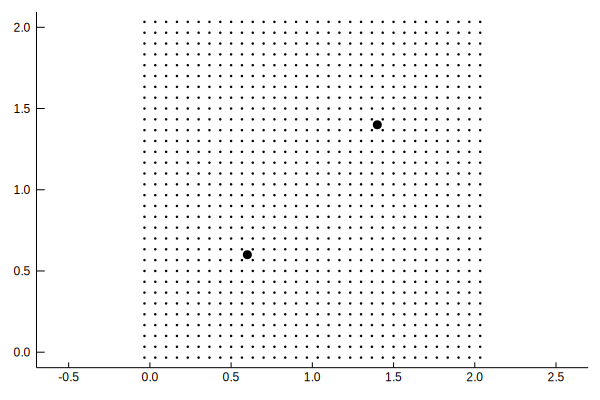

In [36]:
scatter(first.(coord)[:],last.(coord)[:],markercolor=:black,markerstrokecolor=:black,ratio=:equal,markersize=0.5,legend=false,)
scatter!([sol[1][1],sol[1][2]],[sol[1][3],sol[1][4]],markercolor=:black,legend=:none)

# savefig("corotating_vortex_pair.pdf")

In [100]:
q=curl(ψ_array[1])/(dx);

In [101]:
wx_fig = Nodes(Dual,(nx,ny)); wy_fig = deepcopy(wx_fig);
Fields.interpolate!((wx_fig,wy_fig),q);

In [102]:
typeof(wx_fig[:])

Array{Float64,1}

In [110]:
scatter(first.(coord)[:],last.(coord)[:],markercolor=:black,markerstrokecolor=:black,ratio=:equal,markersize=0.5,legend=false,)
plot!(xg,yg,ψ_array[1],levels=contourlevels,c=:YlOrRd,linewidth=2,xlims=(0,Lx),ylims=(0,Lx),legend=false,size=[400,400])
scatter!([sol[1][1],sol[1][2]],[sol[1][3],sol[1][4]],markercolor=:black,legend=:none)
quiver!(first.(coord)[:],last.(coord)[:], quiver=(0.05*wx_fig[:], 0.04*wy_fig[:]),xlims=(0,Lx),ylims=(0,Lx),legend=false,size=[400,400],c=:grey)
savefig("corotating_vortex_pair_velocity.pdf")


### Animation

In [17]:
anim = @animate for i=1:length(sol.t)
    scatter(first.(coord)[:],last.(coord)[:],markercolor=:black,markerstrokecolor=:black,ratio=:equal,markersize=0.5,legend=false)
    plot!(xg,yg,ψ_array[i],levels=contourlevels,c=:YlOrRd,linewidth=2,xlims=(0,Lx),ylims=(0,Lx),legend=false,size=[400,400])
    scatter!([sol[i][1]],[sol[i][3]],markercolor=:black)
    scatter!([sol[i][2]],[sol[i][4]],markercolor=:black)
end
gif(anim, "corotating_vortex_pair_fps15.gif", fps = 15)

┌ Info: Saved animation to 
│   fn = /Users/beckers/Google Drive/Academic/UCLA/CodingInProgress/ViscousFlow.jl/notebooks/corotating_vortex_pair_fps15.gif
└ @ Plots /Users/beckers/.julia/packages/Plots/l0VjU/src/animation.jl:90


Plots.AnimatedGif("/Users/beckers/Google Drive/Academic/UCLA/CodingInProgress/ViscousFlow.jl/notebooks/corotating_vortex_pair_fps15.gif")

### Analytical results

In [50]:
d = sqrt((vortices[1].x-vortices[2].x)^2 + (vortices[1].y-vortices[2].y)^2)

1.131370849898476

#### Opposite circulation

In [51]:
U = vortices[1].Γ/(4π*d)
println("Analytical self-induced velocity = $U")
println("Analytical distance traveled = $(U*tf)")
println("Numerical distance traveled = $(sol[1][1]-sol[end][1])")

Analytical self-induced velocity = 0.07033721219977392
Analytical distance traveled = 0.3467624561448854
Numerical distance traveled = -0.6414543006780767


#### Equal circulation

In [52]:
T = 2π^2*d^2/vortices[1].Γ
println("Analytical period = $T")

Analytical period = 25.26618726678876


In [70]:
0.050550532375431945/1.5915494309189535

0.031761836229142

In [71]:
dx*2

0.031746031746031744